Reinforcement learning exercises
===
Following the tutorials by David Silver; these exercises can be found
[here](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf)

In [46]:
%matplotlib notebook
import datetime
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

In [47]:
# This lets us do some nice video animation stuff.
from tempfile import NamedTemporaryFile
from IPython.display import HTML
from matplotlib import animation
import base64

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return VIDEO_TAG.format(anim._encoded_video)

def display_inline_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [48]:
# Define some constants.
INIT = -1
HIT = 1
STICK = 2
TERMINAL = 3

In [49]:
class CardSource(object):
    def __init__(self):
        pass

    def draw_card(self):
        # Draw a card with value 1-10 (incl); negate with probability 1/3.
        mag = np.random.randint(1, 11)
        return -mag if np.random.randint(0, 3) == 0 else mag

class DebugCardSource(object):
    def __init__(self, deck):
        self.c = 0
        self.deck = deck

    def draw_card(self):
        card = self.deck[self.c]
        self.c += 1
        return card

class Easy21(object):
    def __init__(self, card_source=CardSource()):
        self.card_source = card_source
        self.player = abs(self.card_source.draw_card())
        self.dealer = abs(self.card_source.draw_card())
        self.terminal = False
        self.reward = 0.

    def step(self, action):
        self.__update_state(action)

    def as_index_pair(self):
        return self.player - 1, self.dealer - 1

    def __bust(self, hand):
        return hand < 1 or hand > 21

    def __play_dealer_out(self):
        while self.dealer < 17 and not self.__bust(self.dealer):
            self.dealer += self.card_source.draw_card()

    def __update_state(self, action):
        if action == HIT:
            self.player = self.player + self.card_source.draw_card()
            if self.__bust(self.player):
                self.terminal = True
                self.reward = -1.
        elif action == STICK:
            self.__play_dealer_out()
            self.terminal = True
            if self.__bust(self.dealer) or self.dealer < self.player:
                self.reward = 1.
            elif self.dealer > self.player:
                self.reward = -1.
            else:
                self.reward = 0.
        elif action == TERMINAL:
            return
        else:
            raise ValueError("Unexpected action value: %d" % action)

    def __str__(self):
        return ", ".join(
            [str(x) for x in
             [self.player, self.dealer, self.terminal, self.reward]])

In [50]:
def epsilon_greedy(epsilon, actions, action_values):
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    else:
        return actions[
            np.random.choice(np.where(action_values == action_values.max())[0])]

In [51]:
class MonteCarloControl(object):
    def __init__(self, discount=1., N0=100):
        self.N0 = N0
        self.discount = discount
        self.state_action_values = np.zeros(shape=[21, 10, 2])
        self.state_action_counts = np.zeros(shape=[21, 10, 2])
        self.state_counts = np.zeros(shape=[21, 10])

    def __epsilon(self, state_count):
        return float(self.N0) / float(self.N0 + state_count)

    def select_action(self, easy_21):
        p_idx, d_idx = easy_21.as_index_pair()
        epsilon = self.__epsilon(self.state_counts[p_idx, d_idx])
        return epsilon_greedy(
            epsilon,
            [HIT, STICK],
            self.state_action_values[p_idx, d_idx, :])

    def improve(self, eval_results):
        returns = 0
        reward = eval_results[-1][3]
        a_idx = eval_results[-1][2] - 1
        for state in reversed(eval_results[:-1]):
            p_idx = state[0] - 1
            d_idx = state[1] - 1
            # G_t = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T-1} R_T
            returns = reward + self.discount * returns
            self.state_counts[p_idx, d_idx] += 1
            self.state_action_counts[p_idx, d_idx, a_idx] += 1
            alpha = 1. / self.state_action_counts[p_idx, d_idx, a_idx]
            previous_value = self.state_action_values[
                p_idx, d_idx, a_idx]
            update = alpha * (returns - previous_value)
            self.state_action_values[p_idx, d_idx, a_idx] += update
            reward = state[3]
            a_idx = state[2] - 1

In [61]:
class ActionValueFunctionAnimator(object):
    def __init__(self, frames):
        self.frames = frames
        plt.ioff()
        self.animation_fig = plt.figure(figsize=(5, 5), dpi=100)
        self.animation_ax = self.animation_fig.gca(projection='3d')
        plt.ion()

    def __init_animation(self):
        self.__plot(np.zeros(shape=(21, 10, 2)), self.animation_ax)

    def animate(self):
        def really_animate(i):
            self.animation_ax.clear()
            self.__plot(self.frames[i], self.animation_ax)
        return really_animate

    def display_animation(self):
        anim = animation.FuncAnimation(
            self.animation_fig,
            self.animate(),
            init_func=self.__init_animation,
            frames=len(self.frames),
            interval=40,
            blit=True)
        return display_inline_animation(anim)

    def __plot(self, state_action_values, ax):
        xs = np.arange(0, 10)
        ys = np.arange(0, 21)
        xs, ys = np.meshgrid(xs, ys)
        ax.set_xlabel('dealer')
        ax.set_ylabel('player')
        ax.set_zlabel('value')
        ax.set_zlim(-1., 1.)
        ax.plot_surface(
            xs, ys, state_action_values[:, :, 0],
            rstride=1, cstride=1,
            linewidth=.5, color=(.8, .25, .25, .5))
        ax.plot_surface(
            xs, ys, state_action_values[:, :, 1],
            rstride=1, cstride=1,
            linewidth=.5, color=(.25, .5, .8, .5) )

In [62]:
def evaluate_policy(policy, card_source=CardSource()):
    result = []
    easy21 = Easy21(card_source)
    result.append([easy21.player, easy21.dealer, INIT, easy21.reward])
    while not easy21.terminal:
        action = policy(easy21)
        easy21.step(action)
        result.append([easy21.player, easy21.dealer, action, easy21.reward])
    return result

In [63]:
mcc = MonteCarloControl(N0=500)

num_iter = 100000
frame_freq = 100
frames = []
print("learning")
for i in range(num_iter):
    eval_results = evaluate_policy(mcc.select_action)
    mcc.improve(eval_results)
    if i % frame_freq == 0:
        frames.append(np.copy(mcc.state_action_values))

# The video doesn't render on github, so there are some
# static versions in the repo. For the MCC video, see
# https://github.com/cgs1019/rl/blob/master/sarsa_lambda_2e-1.m4v
# You'll need to "view raw" and download the video.
# It works on a mac. Not sure about other systems.
print("rendering")
animator = ActionValueFunctionAnimator(frames)
animator.display_animation()

learning
rendering


In [56]:
class Sarsa(object):
    def __init__(self, lambda_param, N0=100, discount_factor=1):
        self.N0 = N0
        self.lambda_param = lambda_param
        self.state_counts = np.zeros(shape=(21, 10))
        self.state_action_counts = np.zeros(shape=(21, 10, 2))
        self.state_action_values = np.zeros(shape=(21, 10, 2))
        self.reset_eligibility_traces()
        self.discount_factor = discount_factor

    def reset_eligibility_traces(self):
        self.eligibility_traces = np.zeros(shape=(21, 10, 2))

    def __epsilon(self, state_count):
        return float(self.N0) / float(self.N0 + state_count)

    def select_action(self, easy_21):
        if easy_21.terminal:
            return TERMINAL
        p_idx, d_idx = easy_21.as_index_pair()
        epsilon = self.__epsilon(self.state_counts[p_idx, d_idx])
        return epsilon_greedy(
            epsilon,
            [HIT, STICK],
            self.state_action_values[p_idx, d_idx, :])

    def improve(
        self, pre_state, pre_action, reward, post_state, post_action):

        pre_value = self.state_action_values[
            pre_state[0] - 1, pre_state[1] - 1]
        post_value = 0 if post_action == TERMINAL else (
            self.state_action_values[post_state[0] - 1,
                                     post_state[1] - 1])

        delta = reward + self.discount_factor * post_value - pre_value
        self.eligibility_traces[
            pre_state[0] - 1,
            pre_state[1] - 1,
            pre_action - 1] += 1
        
        self.state_action_counts[
            pre_state[0] - 1,
            pre_state[1] - 1,
            pre_action - 1] += 1

        alpha = 1. / self.state_action_counts[
            pre_state[0] - 1,
            pre_state[1] - 1,
            pre_action - 1]

        self.state_action_values += (
            alpha * delta * self.eligibility_traces)
        self.eligibility_traces *= (
            self.discount_factor * self.lambda_param)

In [57]:
frames = []
print("learning")
sarsa = Sarsa(lambda_param = .2)
for i in range(100000):
    easy21 = Easy21()
    action = sarsa.select_action(easy21)
    sarsa.reset_eligibility_traces()
    while not easy21.terminal:
        pre_state = [easy21.player, easy21.dealer]
        pre_action = action

        easy21.step(action)
        reward = easy21.reward
        post_state = [easy21.player, easy21.dealer]

        action = sarsa.select_action(easy21)
        post_action = action

        sarsa.improve(
            pre_state, pre_action, reward, post_state, post_action)
    if i % 100 == 0:
        frames.append(np.copy(sarsa.state_action_values))

# The video doesn't render on github, so there are some
# static versions in the repo. For the MCC video, see
# https://github.com/cgs1019/rl/blob/master/sarsa_lambda_2e-1.m4v
# You'll need to "view raw" and download the video.
# It works on a mac. Not sure about other systems.
animator = ActionValueFunctionAnimator(frames)
animator.display_animation()

learning


In [83]:
DEALER_INTERVALS = [(1, 4), (4, 7), (7, 10)]
PLAYER_INTERVALS = [(1, 6), (4, 9), (7, 12),
                    (10, 15), (13, 18), (16, 21)]
# return feature vector with bias for state-action combo
def phi(player, dealer, action):
    output = np.zeros(37)
    output[36] = 1  # bias
    is_in = lambda x, interval: x >= interval[0] and x <= interval[1]
    bit_offset = 0
    for a in [HIT, STICK]:
        for p in PLAYER_INTERVALS:
            for d in DEALER_INTERVALS:
                output[bit_offset] = (
                    is_in(player, p) and
                    is_in(dealer, d) and
                    action == a)
                bit_offset += 1
    return output

In [86]:
class LinearApproximationSarsa(object):
    def __init__(self, epsilon, step_size, lambda_param,
                 N0=100, discount_factor=1):
        self.N0 = N0
        self.epsilon = epsilon
        self.step_size = step_size
        self.lambda_param = lambda_param
        self.weights = np.zeros(shape=37)
        self.reset_eligibility_traces()
        self.discount_factor = discount_factor

    def reset_eligibility_traces(self):
        self.eligibility_traces = np.zeros(shape=(37))

    def select_action(self, easy21):
        if easy21.terminal:
            return TERMINAL
        p_idx, d_idx = easy21.as_index_pair()
        action_values = np.array([
            np.dot(self.weights, phi(easy21.player, easy21.dealer, HIT)),
            np.dot(self.weights, phi(easy21.player, easy21.dealer, STICK))])
        return epsilon_greedy(self.epsilon, [HIT, STICK], action_values)

    def improve(
        self, pre_state, pre_action, reward, post_state, post_action):

        pre_vector = phi(pre_state[0], pre_state[1], pre_action)
        pre_value = np.dot(pre_vector, self.weights)
        post_vector = np.zeros(shape=(36)) if post_action == TERMINAL else (
            phi(post_state[0], post_state[1], post_action))
        post_value = np.dot(post_vector, self.weights)

        delta = reward + self.discount_factor * post_value - pre_value
        self.eligibility_traces *= self.discount_factor * self.lambda_param
        self.eligibility_traces += pre_vector

        self.weights += self.step_size * delta * self.eligibility_traces

In [93]:
frames = []
print("learning")
linapprox = LinearApproximationSarsa(
    epsilon = .05,
    step_size = .01,
    lambda_param = 1.,
    discount_factor = .8)
mses = []
for i in range(200000):
    easy21 = Easy21()
    action = linapprox.select_action(easy21)
    linapprox.reset_eligibility_traces()
    while not easy21.terminal:
        pre_state = [easy21.player, easy21.dealer]
        pre_action = action

        easy21.step(action)
        reward = easy21.reward
        post_state = [easy21.player, easy21.dealer]

        action = linapprox.select_action(easy21)
        post_action = action

        linapprox.improve(
            pre_state, pre_action, reward, post_state, post_action)
    if i % 1000 == 0:
        state_action_values = np.zeros(shape=(21, 10, 2))
        for p in range(1, 22):
            for d in range(1, 11):
                for a in [HIT, STICK]:
                    s_a_vector = phi(p, d, a)
                    state_action_values[p - 1, d - 1, a - 1] = np.dot(
                        linapprox.weights, s_a_vector)
        #frames.append(state_action_values)
        mses.append(np.sum(
                (state_action_values - mcc.state_action_values) ** 2))

print("rendering")
#animator = ActionValueFunctionAnimator(frames)
#animator.display_animation()

learning
rendering


<IPython.core.display.Javascript object>


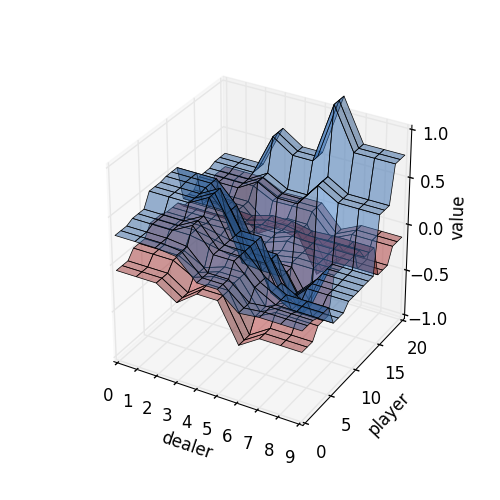

In [94]:
state_action_values = np.zeros(shape=(21, 10, 2))
for p in range(1, 22):
    for d in range(1, 11):
        for a in [HIT, STICK]:
            s_a_vector = phi(p, d, a)
            state_action_values[p - 1, d - 1, a - 1] = np.dot(
                linapprox.weights, s_a_vector)

fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca(projection='3d')

xs = np.arange(0, 10)
ys = np.arange(0, 21)
xs, ys = np.meshgrid(xs, ys)
ax.set_xlabel('dealer')
ax.set_ylabel('player')
ax.set_zlabel('value')
ax.set_zlim(-1., 1.)
ax.plot_surface(
    xs, ys, state_action_values[:, :, 0],
    rstride=1, cstride=1,
    linewidth=.5, color=(.8, .25, .25, .5))
ax.plot_surface(
    xs, ys, state_action_values[:, :, 1],
    rstride=1, cstride=1,
    linewidth=.5, color=(.25, .5, .8, .5) )
plt.show()

<IPython.core.display.Javascript object>


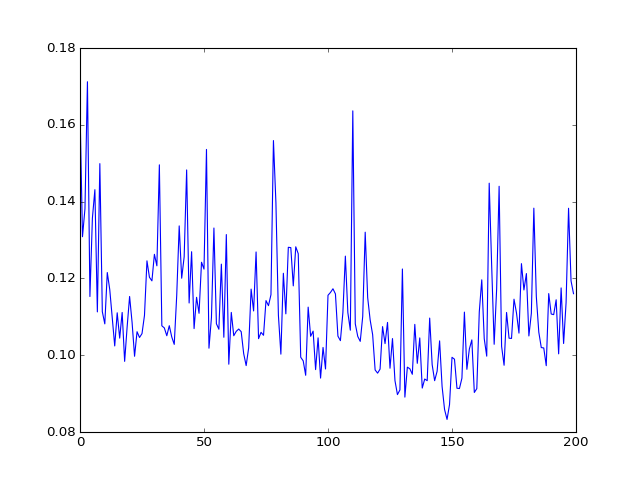

In [95]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.array(mses)/420.)
plt.show()